# Python Model, Governed by SAS - Readmission Prediction

## Load packages

In [51]:
#Import packages#
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
from IPython.display import IFrame
import pygal

## Load data from local computer

In [52]:
df =pd.read_csv('C:/Users/canmfs/OneDrive - SAS/__Demos/Data/READMISSIONS_MODEL.csv')
df.head(5)

,Admit_Date,Diagnosis,Readmitted,Length_of_Stay,Prior_IP_Admits,Chronic_Conditions_Number,Patient_Age,Order_Set_Used,Total_Charges,Discharge_Notes,Patient_Gender,Urban_Class,Marital_Status,Repeat_Care_Offenders,High_NA_at_Discharge,bmi,Contact_Preference,_PARTIND_
0,2-Jun-15,AMI,1,9,4,1,73,1,7231.8750,"ROUTINE DSCHG, HOME",M,U,Y,N,N,19.9,home visit,1
1,27-Aug-13,AMI,0,5,5,2,52,1,7214.3750,"ROUTINE DSCHG, HOME",M,U,Y,N,N,22.1,email,1
2,11-Aug-14,AMI,0,4,4,2,73,0,30360.3125,OTHER DEATH,F,R,N,Y,Y,34.3,text,0
3,7-Mar-14,AMI,0,5,4,2,58,0,13494.6875,"ROUTINE DSCHG, HOME",F,U,N,N,Y,25.2,text,1
4,14-Mar-14,AMI,0,4,4,2,41,0,30541.8750,"ROUTINE DSCHG, HOME",M,U,Y,N,N,18.0,text,0


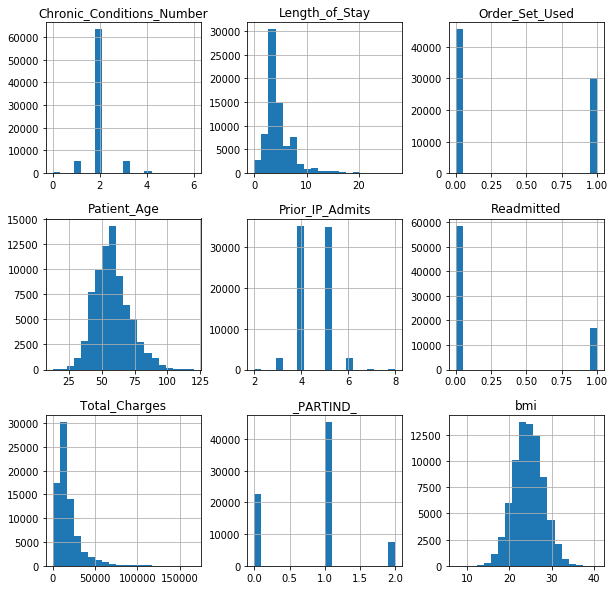

In [53]:
#Visualize numeric variable using histograms 
df.hist(bins=20,figsize=(10,10))
plt.show()

## Data preparation

In [54]:
df.drop("Admit_Date",axis=1,inplace=True)
df.drop("Discharge_Notes",axis=1,inplace=True)
df.drop("Diagnosis",axis=1,inplace=True)
df.drop("Contact_Preference",axis=1,inplace=True)
df.head()

,Readmitted,Length_of_Stay,Prior_IP_Admits,Chronic_Conditions_Number,Patient_Age,Order_Set_Used,Total_Charges,Patient_Gender,Urban_Class,Marital_Status,Repeat_Care_Offenders,High_NA_at_Discharge,bmi,_PARTIND_
0,1,9,4,1,73,1,7231.8750,M,U,Y,N,N,19.9,1
1,0,5,5,2,52,1,7214.3750,M,U,Y,N,N,22.1,1
2,0,4,4,2,73,0,30360.3125,F,R,N,Y,Y,34.3,0
3,0,5,4,2,58,0,13494.6875,F,U,N,N,Y,25.2,1
4,0,4,4,2,41,0,30541.8750,M,U,Y,N,N,18.0,0


In [55]:
# Prepare the data
df["Patient_Gender"] = df["Patient_Gender"].eq('F').mul(1).values
df["Repeat_Care_Offenders"] = df["Repeat_Care_Offenders"].eq('Y').mul(1).values
df["Urban_Class"] = df["Urban_Class"].eq('U').mul(1).values
df["Marital_Status"] = df["Marital_Status"].eq('Y').mul(1).values
df["High_NA_at_Discharge"] = df["High_NA_at_Discharge"].eq('Y').mul(1).values
df = df.apply(pd.to_numeric)
df.head()

,Readmitted,Length_of_Stay,Prior_IP_Admits,Chronic_Conditions_Number,Patient_Age,Order_Set_Used,Total_Charges,Patient_Gender,Urban_Class,Marital_Status,Repeat_Care_Offenders,High_NA_at_Discharge,bmi,_PARTIND_
0,1,9,4,1,73,1,7231.8750,0,1,1,0,0,19.9,1
1,0,5,5,2,52,1,7214.3750,0,1,1,0,0,22.1,1
2,0,4,4,2,73,0,30360.3125,1,0,0,1,1,34.3,0
3,0,5,4,2,58,0,13494.6875,1,1,0,0,1,25.2,1
4,0,4,4,2,41,0,30541.8750,0,1,1,0,0,18.0,0


## EDA

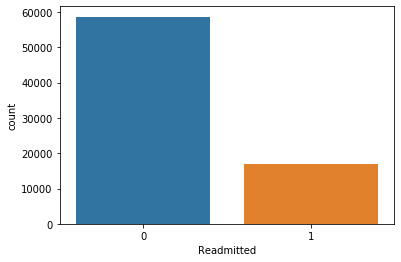

In [56]:
# Target distribution
sns.countplot(x="Readmitted", data=df)

In [57]:
# Correlation check
corr = df.corr()
corr.style.background_gradient(cmap='Paired')

,Readmitted,Length_of_Stay,Prior_IP_Admits,Chronic_Conditions_Number,Patient_Age,Order_Set_Used,Total_Charges,Patient_Gender,Urban_Class,Marital_Status,Repeat_Care_Offenders,High_NA_at_Discharge,bmi,_PARTIND_
Readmitted,1,0.485702,-0.000725243,0.0618234,0.579808,0.301766,-0.0549391,0.0031349,-0.00204016,-0.00330943,0.00211494,0.000289908,0.00490215,0.000951167
Length_of_Stay,0.485702,1,0.00359815,0.0179046,0.282827,0.144995,0.378376,0.00346973,-0.00174882,-0.00546286,0.00420166,0.00160979,0.0014694,0.00174277
Prior_IP_Admits,-0.000725243,0.00359815,1,0.00207659,0.00178876,0.00823872,-0.000815386,0.000842588,0.00296557,0.000602697,-0.00335294,-0.00235699,-0.00133726,-0.00178512
Chronic_Conditions_Number,0.0618234,0.0179046,0.00207659,1,0.0386405,0.0163131,0.096749,-0.00122464,0.00576631,0.00137861,-0.00767749,-0.00138738,-0.00119332,0.00213847
Patient_Age,0.579808,0.282827,0.00178876,0.0386405,1,0.172083,-0.0319123,-0.00161438,0.00290165,0.00157436,-0.00470811,-0.00460957,0.00171284,0.000816952
Order_Set_Used,0.301766,0.144995,0.00823872,0.0163131,0.172083,1,-0.0204757,0.000632585,-0.000250416,-0.00223946,-0.000730027,0.00117072,-0.00484049,-0.000431285
Total_Charges,-0.0549391,0.378376,-0.000815386,0.096749,-0.0319123,-0.0204757,1,-0.000186313,0.00132665,-0.00028639,-0.0013766,-0.00121744,-0.00304251,-0.00505313
Patient_Gender,0.0031349,0.00346973,0.000842588,-0.00122464,-0.00161438,0.000632585,-0.000186313,1,-0.605457,-0.901824,0.494433,0.829416,0.0014241,-9.39298e-05
Urban_Class,-0.00204016,-0.00174882,0.00296557,0.00576631,0.00290165,-0.000250416,0.00132665,-0.605457,1,0.671369,-0.816627,-0.729979,-0.0024063,0.00440898
Marital_Status,-0.00330943,-0.00546286,0.000602697,0.00137861,0.00157436,-0.00223946,-0.00028639,-0.901824,0.671369,1,-0.548258,-0.919709,-0.00365235,0.00130218


# Modelling

## Declare variables 

In [58]:
#Convert Write off from int to category
df['Readmitted']=df['Readmitted'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75675 entries, 0 to 75674
Data columns (total 14 columns):
Readmitted                   75675 non-null category
Length_of_Stay               75675 non-null int64
Prior_IP_Admits              75675 non-null int64
Chronic_Conditions_Number    75675 non-null int64
Patient_Age                  75675 non-null int64
Order_Set_Used               75675 non-null int64
Total_Charges                75675 non-null float64
Patient_Gender               75675 non-null int32
Urban_Class                  75675 non-null int32
Marital_Status               75675 non-null int32
Repeat_Care_Offenders        75675 non-null int32
High_NA_at_Discharge         75675 non-null int32
bmi                          75675 non-null float64
_PARTIND_                    75675 non-null int64
dtypes: category(1), float64(2), int32(5), int64(6)
memory usage: 6.1 MB


In [59]:
#df = df.apply(pd.to_numeric)

In [60]:
#split dataset in features and target variable
predictors = ['Length_of_Stay', 'Prior_IP_Admits', 'Chronic_Conditions_Number', 'Patient_Age',
              'Order_Set_Used', 'Total_Charges', 'Patient_Gender', 'Urban_Class', 'Marital_Status',
              'Repeat_Care_Offenders', 'High_NA_at_Discharge', 'bmi']
X = df[predictors] # Features
y=df['Readmitted']

## Modelling on training set

In [61]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
# Quick check of which model works best
classifiers = [
    LogisticRegression(random_state=123),
    DecisionTreeClassifier(random_state=123),
    RandomForestClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123)
    ]

labels = ['Logit', 'DTree', 'RFor', 'GBoost']

models = []
models_dic = {}

for label, classifier in zip(labels, classifiers):
    model = classifier.fit(X_train, y_train.values.ravel())
    models_dic = {'label': label, 'model': model}
    models.append(models_dic)

import pprint
pprint.pprint(models)

[{'label': 'Logit',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)},
 {'label': 'DTree',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')},
 {'label': 'RFor',
  'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                   

In [63]:
#Check misclassification rate of the above models
print('Misclassification Rates')
for m in models:
    dt_misclassification = 1 - metrics.accuracy_score(y_test, m['model'].predict(X_test))
    print('{} :'.format(m['label']), dt_misclassification) # Random Forest is the best model 0.3673333333333333

Misclassification Rates
Logit : 0.10423257117687101
DTree : 0.08437112081047526
RFor : 0.05942417811236134
GBoost : 0.05209626396508227


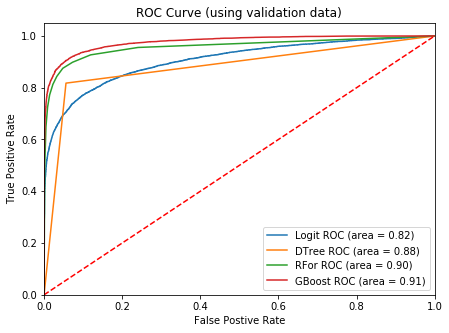

In [64]:
#Plot ROC Curve
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

In [65]:
# Only keep Decision Tree and Random Forest as challengers
del_models = ['Logit', 'GBoost']        
models = [model_dict for model_dict in models if model_dict['label'] not in del_models]

In [66]:
# Create a XGBoost model
xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.08696	validation_0-logloss:0.62397	validation_1-error:0.08854	validation_1-logloss:0.62403
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.08278	validation_0-logloss:0.56707	validation_1-error:0.08345	validation_1-logloss:0.56713
[2]	validation_0-error:0.07526	validation_0-logloss:0.51623	validation_1-error:0.07576	validation_1-logloss:0.51652
[3]	validation_0-error:0.07783	validation_0-logloss:0.47331	validation_1-error:0.07845	validation_1-logloss:0.47392
[4]	validation_0-error:0.06966	validation_0-logloss:0.43756	validation_1-error:0.07144	validation_1-logloss:0.43826
[5]	validation_0-error:0.06674	validation_0-logloss:0.40594	validation_1-error:0.06751	validation_1-logloss:0.40665
[6]	validation_0-error:0.06775	validation_0-logloss:0.37871	validation_1-error:0.06843	validation_1-logloss:0.37945
[7]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, xgb.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification) #0.3983333333333333

Misclassification Rates
 XGBoost : 0.05221639370520159


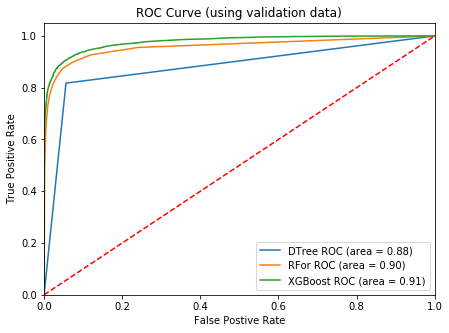

In [68]:
#Compare Gboost, RF and XGBoost
models.append({'label': 'XGBoost','model': xgb})
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()  #Decision tree and Forest are still better than XGBoost

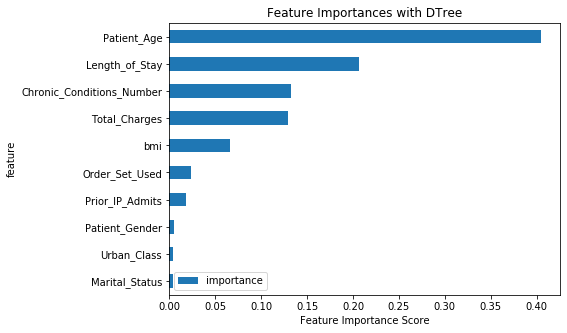

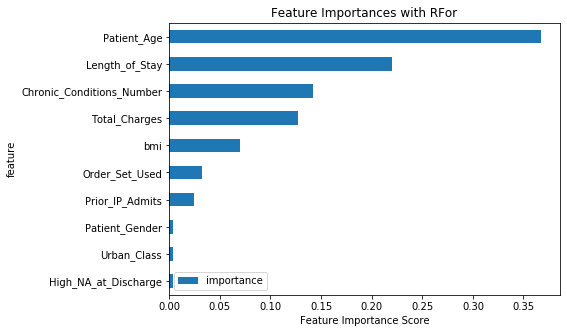

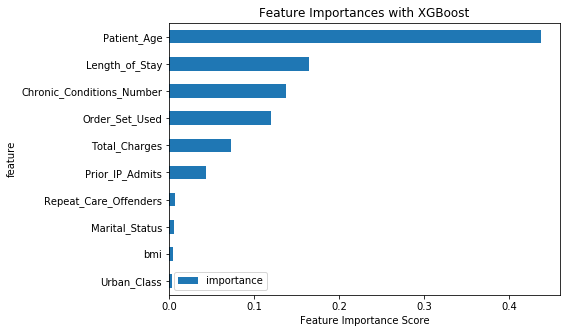

In [69]:
#Check feature importance
for m in models:
    model = m['model']
    feat_imp = pd.DataFrame({'importance':model.feature_importances_})
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:10]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title='Feature Importances with {}'.format(m['label']), figsize=(7, 5))
    plt.xlabel('Feature Importance Score')
    plt.show()

# Model Management with Python models in SAS Model Manager

## Set up a connection with CAS

In [70]:
import sasctl
from sasctl import pzmm as pzmm

In [71]:
#Random Forest Pipeline
rfor_pipeline = Pipeline(steps=[('classifier', RandomForestClassifier(random_state=123))])

In [72]:
#Decision Tree Pipeline
dtree_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=123))])

In [73]:
#Test pipeline in production: Create training data
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(X, y,  
                                                    test_size=0.3, random_state=123)

In [74]:
rfor_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=rfor_pipeline.predict_proba(Prod_X_test)
#check score for RF
rfor_pipeline.score(Prod_X_test, Prod_y_test) 

0.9405364929744967

In [75]:
dtree_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=dtree_pipeline.predict_proba(Prod_X_test)
#check score for Decision Tree
dtree_pipeline.score(Prod_X_test, Prod_y_test)

0.9169272783332599

In [76]:
trainedModel_RF=rfor_pipeline
trainedModel_DT=dtree_pipeline

In [77]:
#Define output variable: Random Forest
yCategory_RF = trainedModel_RF.predict(X)
yProb_RF=1-trainedModel_RF.predict_proba(X)
outputVar_RF = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar_RF['EM_CLASSIFICATION'] = yCategory_RF.astype('str')
outputVar_RF['EM_EVENTPROBABILITY'] = yProb_RF

In [78]:
#Define output variable: Decision Tree
yCategory_DT = trainedModel_DT.predict(X)
yProb_DT=1-trainedModel_DT.predict_proba(X)
outputVar_DT = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar_DT['EM_CLASSIFICATION'] = yCategory_DT.astype('str')
outputVar_DT['EM_EVENTPROBABILITY'] = yProb_DT

In [79]:
targetName = 'Readmitted'
targetValue = 1

In [80]:
from pathlib import Path
dataFolder = Path.cwd()/'Data'
zipFolder_RF = Path.cwd()/'Model'/'Random_Forest_Readmit'
zipFolder_DT= Path.cwd()/'Model'/'Decision_Tree_Readmit'

In [81]:
modelPrefix_RF='OS_ReadmitForest'
PickleModel=pzmm.PickleModel()
PickleModel.pickleTrainedModel(trainedModel_RF,modelPrefix_RF,zipFolder_RF)
modelPrefix_DT='OS_ReadmitDTree'
PickleModel.pickleTrainedModel(trainedModel_DT, modelPrefix_DT,zipFolder_DT)

### Write Metadata

In [82]:
#Forest
JSONFiles = pzmm.JSONFiles()
JSONFiles.writeVarJSON(X, isInput=True, jPath=zipFolder_RF)

JSONFiles.writeVarJSON(outputVar_RF, isInput=False, jPath=zipFolder_RF)

modelName = 'OS Patient Readmission Random Forest'
JSONFiles.writeModelPropertiesJSON(modelName=modelName,
                                        modelDesc='',
                                        targetVariable=targetName,
                                        modelType='Random Forest',
                                        modelPredictors= (X),
                                        targetEvent=yCategory_RF[1].astype('str'),
                                        numTargetCategories=len(yCategory_RF),
                                        eventProbVar='EM_EVENTPROBABILITY',
                                        jPath=zipFolder_RF)

JSONFiles.writeFileMetadataJSON(modelPrefix_RF, jPath=zipFolder_RF)

In [83]:
#Decision Tree
JSONFiles = pzmm.JSONFiles()
JSONFiles.writeVarJSON(X, isInput=True, jPath=zipFolder_DT)

JSONFiles.writeVarJSON(outputVar_DT, isInput=False, jPath=zipFolder_DT)

modelName = 'OS Patient Readmission Decision Tree'
JSONFiles.writeModelPropertiesJSON(modelName=modelName,
                                        modelDesc='',
                                        targetVariable=targetName,
                                        modelType='Decision Tree',
                                        modelPredictors=(X),
                                        targetEvent=yCategory_DT[1].astype('str'),
                                        numTargetCategories=len(yCategory_DT),
                                        eventProbVar='EM_EVENTPROBABILITY',
                                        jPath=zipFolder_DT)

JSONFiles.writeFileMetadataJSON(modelPrefix_DT, jPath=zipFolder_DT)

### Write FitStats

In [84]:
# Generate Metrics: Forest
yTrainActual_RF = Prod_y_train.to_list()
y_TrainPredict_RF = trainedModel_RF.predict(Prod_X_train)
yTrainPredict_RF=y_TrainPredict_RF.tolist()

yTestActual_RF = Prod_y_test.to_list()
y_TestPredict_RF = trainedModel_RF.predict(Prod_X_test)
yTestPredict_RF=y_TestPredict_RF.tolist()

data=[(None,None),(yTrainActual_RF, yTrainPredict_RF),(yTestActual_RF, yTestPredict_RF)]

JSONFiles = pzmm.JSONFiles()
jsonPath = zipFolder_RF
JSONFiles.calculateFitStat(data, jsonPath)
JSONFiles.generateROCStat(data, targetName, jsonPath)
JSONFiles.generateLiftStat(data, targetName, targetValue, jsonPath)

In [85]:
#Generate Metrics: Decision Tree
yTrainActual_DT = Prod_y_train.to_list()
y_TrainPredict_DT = trainedModel_DT.predict(Prod_X_train)
yTrainPredict_DT=y_TrainPredict_DT.tolist()

yTestActual_DT = Prod_y_test.to_list()
y_TestPredict_DT = trainedModel_DT.predict(Prod_X_test)
yTestPredict_DT=y_TestPredict_DT.tolist()

data=[(None,None),(yTrainActual_DT, yTrainPredict_DT),(yTestActual_DT, yTestPredict_DT)]

JSONFiles = pzmm.JSONFiles()
jsonPath = zipFolder_DT
JSONFiles.calculateFitStat(data, jsonPath)
JSONFiles.generateROCStat(data, targetName, jsonPath)
JSONFiles.generateLiftStat(data, targetName, targetValue, jsonPath)

### Write ScoreCode

In [ ]:
#Decision Tree Marie's
modelName = 'OS Patient Readmission Decision Tree'
predictMethod = f'{trainedModel_DT}.predict_proba({input})'
# Create the score code for the model and write it to the file system
SC = pzmm.ScoreCode()
SC.writeScoreCode(inputDF=X,
                  targetDF=y,
                  pickleName=modelPrefix_DT,
                  modelPrefix=modelPrefix_DT,
                  predictMethod=predictMethod,
                  pyPath=zipFolder_DT)

### Zip Models and Dependencies 

In [ ]:
#ZipModel
ZipModel=pzmm.ZipModel()
ZipModel.zipFiles(fileDir=zipFolder_RF, modelPrefix=modelPrefix_RF)
ZipModel.zipFiles(fileDir=zipFolder_DT, modelPrefix=modelPrefix_DT)

### Push Zipped Files to SAS Model Manager

In [101]:
#Connect with OMM
#host = 'pdcesx16063.exnet.sas.com'
host = 'pdcesx12025.exnet.sas.com'
ModelImport = pzmm.ModelImport(host)

In [105]:
#Push Forest Model into SAS Model Manager
zPath = Path(zipFolder_RF) / (modelPrefix_RF +'.zip')
ModelImport.importModel(modelPrefix_RF, projectName='Readmission Prediction', zPath=zPath)

Enter user name:sasdemo
Enter password for sasdemo:········


In [103]:
#Push DT Model into SAS Model Manager
zPath = Path(zipFolder_DT) / (modelPrefix_DT +'.zip')
ModelImport.importModel(modelPrefix_DT+'_Py'+'_pzmm', projectName='Readmission Prediction', zPath=zPath)

Enter user name:sasdemo
Enter password for sasdemo:········
